In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.policies import policy_saver

2023-06-04 02:39:31.927663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-04 02:39:34.259605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:34.263598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:34.263795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : "pretrain_q_learning",
"new_reward_function" : 2,
"step_size" : 4,
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
session_name = 'rand_walk_interpol'
env = RLEnv(model_path=session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))


2023-06-04 02:39:39.657176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:39.657402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:39.657586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12

2023-06-04 02:39:44.607295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:44.607679: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 02:39:44.608171: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 02:39:44.609553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:44.610487: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-04 02:39:45.689936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:45.690185: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 02:39:45.690433: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 02:39:45.691474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:45.691728: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-04 02:39:49.279271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:49.279508: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 02:39:49.279771: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 02:39:49.280521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:49.280800: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-04 02:39:49.817720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:49.817978: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 02:39:49.818240: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 02:39:49.819278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 02:39:49.819483: I tensorflow/compiler/xla/stream_executor/

In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-04--02:39:50'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-06-04 02:39:52.440669: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-04 02:39:52.440814: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-04 02:40:00.437576: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 18.90670394897461
Average error 21.09329533698509


Timer unit: 0.001 s

Total time: 201.096 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 468

Line #      Hits         Time  Per Hit   % Time  Line Contents
   468                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   469        52          1.7      0.0      0.0  		city_ob = self.building_grid
   470        52          1.7      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   471        52          2.3      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   472                                           
   473                                           		# Get measured coords
   474        52          7.3      0.1      0.0  		measured_coords = self.get_measured_coords()
   475                                           
   476                                           		# UAV location grid
   477        52          1.8      0.0      0.0  		uav_location_grid

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-04 02:43:13.512088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-04 02:43:14.481349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [50]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors), episode_errors

In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=10)

print((rand_reward, rand_pred_error))


(22.15916, 17.84083936020665)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,     
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpsro6ykzt.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpsro6ykzt
[reverb/cc/platform/default/server.cc:71] Started replay server on port 45319


In [17]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([[[ 0.46516785,  0.19775586,  0.        ],
         [ 0.74863064,  0.17252703,  0.        ],
         [ 0.7286331 ,  0.18220359,  0.        ],
         ...,
         [ 0.60377175,  0.20029463,  0.        ],
         [ 0.5724591 ,  0.25196025,  0.        ],
         [ 0.4240596 ,  0.27324   ,  0.        ]],
 
        [[ 0.29381528,  0.17058524,  0.        ],
         [ 0.0687899 ,  0.23970142,  0.        ],
         [-0.00986105,  0.17766815,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.40646148,  0.19694501,  0.        ],
         [ 0.24331552,  0.2108468 ,  0.        ],
         [ 0.        ,  0.20918448,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
env._reset()
print("")

In [22]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [23]:
best_reward = np.inf
losses = []
collect_rewards = []

In [24]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps*3):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1777826) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1777826) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1777826) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1777826) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1777826) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1777826) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2023-06-04 03:28:36.673180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum' with dtype int32
	 [[{{node critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum}}]]
2023-06-04 03:28:36.681670: I tensorflow/core/common_runtime/executor.cc:1197] [/d

step = 0: loss = 4.249319553375244,  rew = 6.509760767221451
step = 1000: loss = 4.198047637939453,  rew = 11.563277244567871
step = 2000: loss = 4.1454267501831055,  rew = 9.006533771753311
step = 3000: loss = 4.09511661529541,  rew = 6.803535670042038
step = 4000: loss = 4.041511535644531,  rew = 3.6626599729061127
step = 5000: loss = 3.9842662811279297,  rew = 19.72949355840683
step = 6000: loss = 3.9404642581939697,  rew = 3.429565206170082
step = 7000: loss = 3.8977010250091553,  rew = 11.401861160993576
step = 8000: loss = 3.8819611072540283,  rew = 14.51910138130188
step = 9000: loss = 3.803609848022461,  rew = 5.318297818303108
step = 10000: loss = 3.7659196853637695,  rew = 7.01051726937294
step = 11000: loss = 3.754318952560425,  rew = 5.936561152338982
step = 12000: loss = 3.7612032890319824,  rew = 15.188029408454895
step = 13000: loss = 3.7289047241210938,  rew = 2.8813185170292854
step = 14000: loss = 3.7038121223449707,  rew = 3.780851885676384
step = 15000: loss = 3.729

In [56]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step.reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
      avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
      print('step = {0}: Average Return 2 = {1}, Average Error 2 = {2}'.format(step, avg_return, avg_error))
      print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

step = 2851000: loss = 3.2784366607666016,  rew = 20.445120334625244
step = 2852000: loss = 3.28546142578125,  rew = 23.29118549823761
step = 2853000: loss = 3.3236582279205322,  rew = 21.9577819108963
step = 2854000: loss = 3.2903854846954346,  rew = 22.363094985485077
step = 2855000: loss = 3.375044584274292,  rew = 24.392788112163544
step = 2856000: loss = 3.29072904586792,  rew = 23.2680544257164
step = 2857000: loss = 3.328882932662964,  rew = 21.85354381799698
step = 2858000: loss = 3.3139796257019043,  rew = 22.534677386283875
step = 2859000: loss = 3.3583059310913086,  rew = 21.55691087245941
step = 2860000: loss = 3.289447069168091,  rew = 23.16581755876541
step = 2861000: loss = 3.332426071166992,  rew = 20.495198667049408
step = 2862000: loss = 3.3489022254943848,  rew = 20.43820172548294
step = 2863000: loss = 3.2594070434570312,  rew = 20.07025182247162
step = 2864000: loss = 3.4260597229003906,  rew = 19.576898217201233
step = 2865000: loss = 3.337923049926758,  rew = 22.

ValueError: too many values to unpack (expected 2)

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

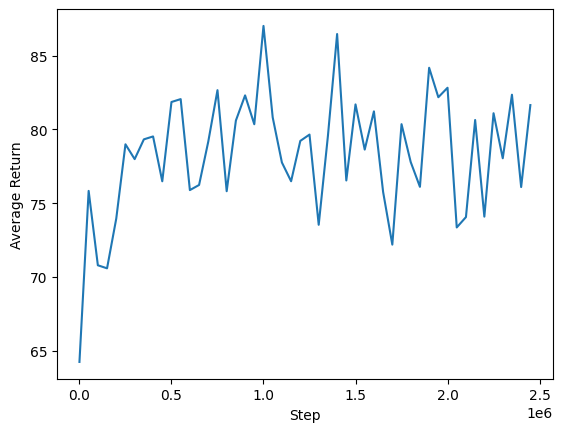

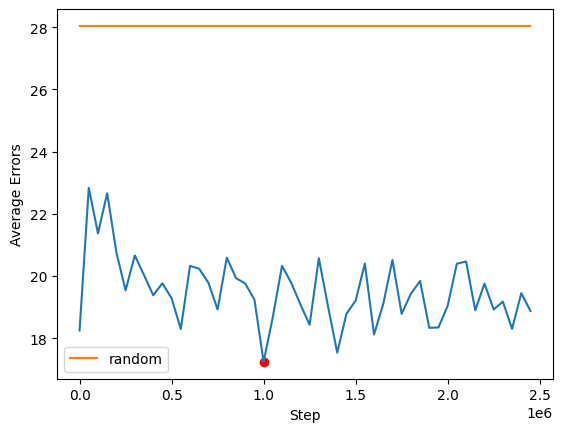

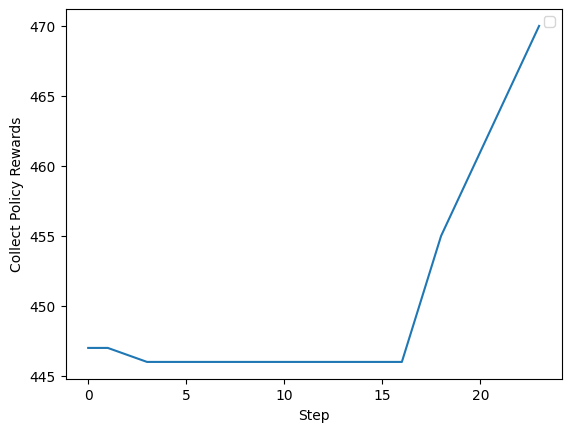

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

22.378853 17.984891216551663


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, saved_policy, 500)
print(avg_return, avg_error)

22.431406 17.9352469711732
